<a href="https://colab.research.google.com/github/Natali-bali/TensorFlow_Tutorial/blob/master/10_Time_series_bitcoin_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Time series forecasting in TensorFlow (BitPredict 💰📈)

The goal of this notebook is to get you familiar with working with time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

### Get helper functions

In [1]:
!wget 'https://raw.githubusercontent.com/Natali-bali/TensorFlow_Tutorial/master/helper_functions.py'

--2021-08-02 11:18:39--  https://raw.githubusercontent.com/Natali-bali/TensorFlow_Tutorial/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11016 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.76K  --.-KB/s    in 0s      

2021-08-02 11:18:39 (82.2 MB/s) - ‘helper_functions.py’ saved [11016/11016]



### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import backend as K 
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Dense, InputLayer
from helper_functions import plot_loss_curves, create_tf_board_callback, compare_historys

### Get Data
Historical data of Bitcoin

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-08-02 11:18:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2021-08-02 11:18:43 (16.4 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [4]:
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv')

In [5]:
df.Date = pd.to_datetime(df.Date)
df = df.rename(columns = {'Date': 'date'}).set_index('date')

In [6]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [7]:
df_bc = df[['Closing Price (USD)']].rename(columns = {'Closing Price (USD)':'price'})

In [8]:
df_bc.head()

,price
date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


### Inspect our data

Text(0.5, 1.0, 'Price of bitcoin from 1 Oct 2013 to 18 May 2021')

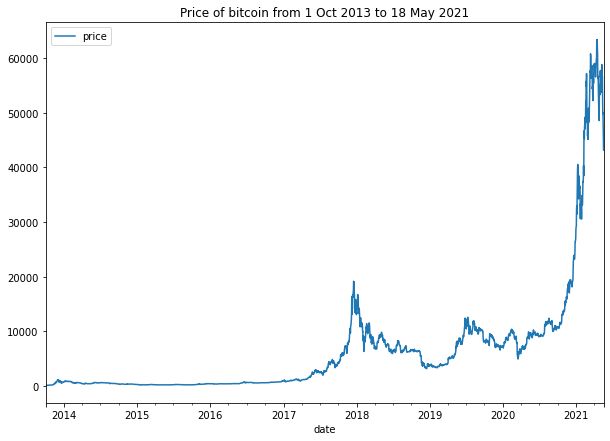

In [9]:
df_bc.plot(figsize = (10,7))
plt.title('Price of bitcoin from 1 Oct 2013 to 18 May 2021')

In [10]:
df_bc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2787 non-null   float64
dtypes: float64(1)
memory usage: 43.5 KB


### Read Data with Python csv

In [11]:
timesteps = []
btc_price = []
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', 'r') as f:
  csv_reader = csv.reader(f, delimiter = ',')
  next(csv_reader) #skip first line (header)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], '%Y-%m-%d'))
    btc_price.append(float(line[2]))

In [12]:
timesteps[:2], btc_price[:2]

([datetime.datetime(2013, 10, 1, 0, 0), datetime.datetime(2013, 10, 2, 0, 0)],
 [123.65499, 125.455])

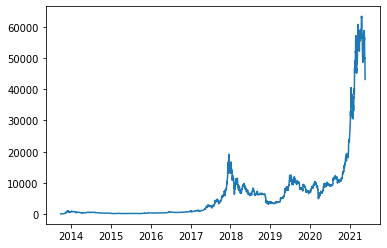

In [13]:
plt.plot(timesteps, btc_price)

### Create test train data sets

In [14]:
train_length = int(0.8*len(timesteps))
X_train, y_train = timesteps[:train_length], btc_price[:train_length]
X_test, y_test = timesteps[train_length:], btc_price[train_length:]

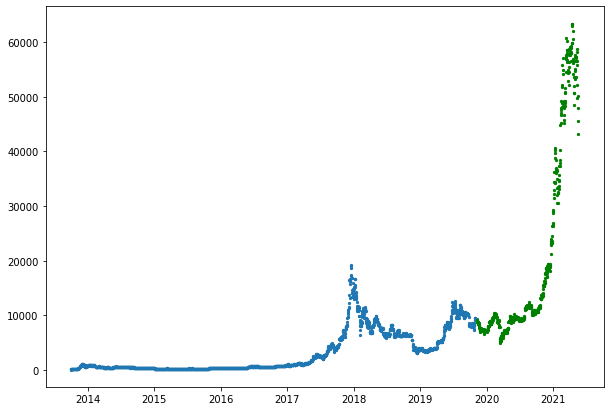

In [15]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s = 5, label = 'Train data')
plt.scatter(X_test, y_test, s = 5, label = 'Test data', c = 'green')
plt.show()

### Helper function to plot time series

In [16]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

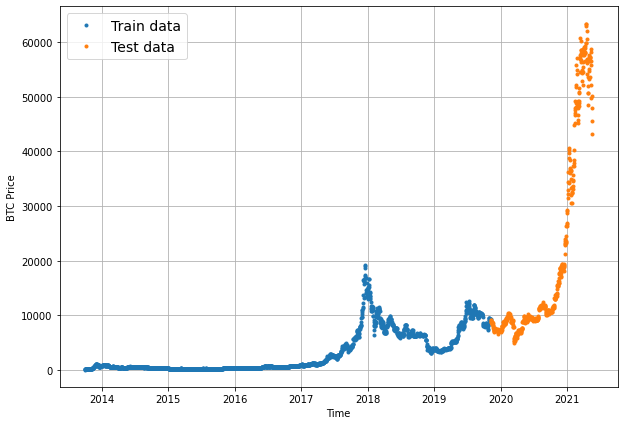

In [17]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

horizon = number of timesteps to predict into future

window = number of timesteps from past used to predict horizon

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

We are going to do those modelling experiments:

- 0 Naïve model (baseline)
- 1	Dense model	horizont 1 window 7
- 2	Same as 1	horizont 1 window	30
- 3	Same as 1	horizont 7 window	30
- 4	Conv1D	horizont 1	window 7
- 5	LSTM	horizont 1	window 7
- 6	Same as 1 (but with multivariate data)	horizont 1	window 7	Block reward size
- 7	N-BEATs Algorithm	horizont 1	window 7
- 8	Ensemble (multiple models optimized on different loss functions)	horizont 1	window 7
- 9	Future prediction model (model to predict future values) horizont	1 window	7
- 10	Same as 1 (but with turkey 🦃 data introduced)	horizont 1	window 7	


### 0 Model: Naive
$$\hat{y}_{t} = y_{t-1}$$

In [18]:
naive_forecast = y_test[:-1]

#### Plot Naive forecast

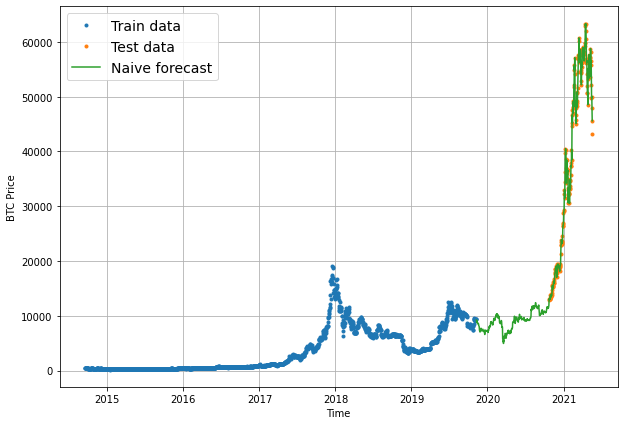

In [19]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, start = 350, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start = 350, label="Test data")
plot_time_series(timesteps=X_test[1:], values = naive_forecast, format = '-', label="Naive forecast")

###Evaluating forecast model
Scale-dependent errors: MAE tf.keras.metrics.mean_absolute_error(), RMSE tf.sqrt(tf.keras.metrics.mean_square_error())

Percentage errors: MAPE tf.keras.metrics.mean_absolute_percentage_error(), sMAPE custom implementation

Scaled errors: MASE See sktime's mase_loss() Less then 1 beats naive predition

In [20]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

    return mae / mae_naive_no_season

In [21]:
mean_absolute_scaled_error(y_true = np.array(y_test[1:]), y_pred = np.array(naive_forecast)).numpy()

0.9995699939182624

#### Function to save all results

In [81]:
df_results = pd.DataFrame(columns = ['model', 'MAE', 'RMSE', 'MAPE', 'MASE', 'last_day_pred', 'last_day_real'])

In [82]:
def save_results(model_name, y_pred, y_true = y_test[1:]):
  y_pred = np.array(y_pred)
  y_true = np.array(y_true)
  MAE = int(mean_absolute_error(y_true, y_pred).numpy())
  RMSE = int(tf.sqrt(tf.keras.metrics.mean_squared_error(y_true, y_pred)).numpy())
  MAPE = round(tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred).numpy(),2)
  MASE = mean_absolute_scaled_error(y_true, y_pred).numpy()
  last_day_pred = y_pred[-1]
  df_results.loc[len(df_results)] = [model_name, MAE, RMSE, MAPE, MASE, last_day_pred, y_true[-1]]

In [83]:
save_results('Base_naive', naive_forecast)

In [84]:
df_results

,model,MAE,RMSE,MAPE,MASE,last_day_pred,last_day_real
0,Base_naive,567,1071,2.52,0.99957,45604.615754,43144.471291


### Other models to try
Moving average	https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/

ARIMA (Autoregression Integrated Moving Average)	https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

sktime (Scikit-Learn for time series)	https://github.com/alan-turing-institute/sktime

TensorFlow Decision Forests (random forest, gradient boosting trees)	https://www.tensorflow.org/decision_forests

Facebook Kats (purpose-built forecasting and time series analysis library by Facebook)	https://github.com/facebookresearch/Kats

LinkedIn Greykite (flexible, intuitive and fast forecasts)	https://github.com/linkedin/greykite


### Format Data: Windowing our data
Windowing for one week:

[0,1,2,3,4,5,6] -> [7]

[1,2,3,4,5,6,7] -> [8]

[2,3,4,5,6,7,8] -> [9]

In [26]:
print(f'We want to use: {y_train[:7]} to predict {y_train[7]}')

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict 123.033


In [27]:
HORIZON = 1
WINDOW_SIZE = 7

In [28]:
#Create the function to label windowed data
def get_labeled_window(x, horizon = HORIZON):
  """Creates labels for windowed dataset.
  input = [0,1,2,3,4,5,6,7] output = [0,1,2,3,4,5,6], [7]
  """
  return x[:, :-horizon], x[:, -horizon:]

In [29]:
test_window, test_labels = get_labeled_window(tf.expand_dims(tf.range(8), axis = 0))

In [30]:
test_window, test_labels

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[7]], dtype=int32)>)

In [31]:
def make_windows(y, window_size = WINDOW_SIZE, horizon = HORIZON):
  """Turns 1D array into sD array of sequental labeled widows"""
  y = np.array(y)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis = 0)
  window_indexes = window_step + np.expand_dims(np.arange(len(y)-(window_size + horizon - 1)), axis=0).T
  # print(f'Window indexes: {window_indexes}\n Window shapes: {window_indexes.shape}')
  windowed_array = y[window_indexes]
  #get labeled windows
  windows, labels = get_labeled_window(windowed_array, horizon = horizon)
  return windows, labels

In [32]:
len(btc_price)

2787

In [33]:
all_windows, all_labels = make_windows(btc_price)

In [34]:
for i in range(3):
  print(f'Window: {all_windows[i]} -> Horizon (label): {all_labels[i]}')

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Horizon (label): [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Horizon (label): [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Horizon (label): [125.96116]


In [35]:
all_windows.shape, all_labels.shape

((2780, 7), (2780, 1))

#### Use tensorflow to create tf.ds
Another way to do this using tf function
 tf.keras.preprocessing.timeseries_dataset_from_array()

In [104]:
test_split = 0.2
split_size = int(len(btc_price) * (1-test_split))
btc_price_train = np.array(btc_price, dtype = 'float32')[:split_size]
btc_price_test = np.array(btc_price, dtype = 'float32')[split_size:]
ds_train = tf.keras.preprocessing.timeseries_dataset_from_array(btc_price_train, 
                                                            targets = btc_price_train[WINDOW_SIZE:], #need to shift right, otherwise give first element
                                                            sequence_length = WINDOW_SIZE, 
                                                            sequence_stride=HORIZON, 
                                                            sampling_rate=HORIZON,
                                                           batch_size = 1)
ds_test = tf.keras.preprocessing.timeseries_dataset_from_array(btc_price_test, 
                                                            targets = btc_price_test[WINDOW_SIZE:], #need to shift right, otherwise give first element
                                                            sequence_length = WINDOW_SIZE, 
                                                            sequence_stride=HORIZON, 
                                                            sampling_rate=HORIZON,
                                                           batch_size = 1)

In [105]:
ds_train, len(ds_train), ds_test, len(ds_test)

(<BatchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>,
 2222,
 <BatchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>,
 551)

In [107]:
#Print if batch_size = 1
for window, label in ds_train.take(3):
    print(tf.squeeze(window).numpy(), '->', label.numpy())

[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> [123.033]
[125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> [124.049]
[108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> [125.96116]


In [ ]:
#Print if batch_size>1
# for batch_window, batch_label in ds_train.take(3):
#     for window, label in zip(tf.squeeze(batch_window).numpy(), batch_label.numpy()):
#       print(window, '->', label)

In [39]:
btc_price[:24]

[123.65499,
 125.455,
 108.58483,
 118.67466,
 121.33866,
 120.65533,
 121.795,
 123.033,
 124.049,
 125.96116,
 125.27966,
 125.9275,
 126.38333,
 135.24199,
 133.20333,
 142.76333,
 137.92333,
 142.95166,
 152.55183,
 160.33883,
 164.31499,
 177.63333,
 188.29716,
 200.70166]

#### Split data (all_windows and all_labels) to train and test sets

In [40]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [41]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(all_windows, all_labels, test_split=0.2)

In [42]:
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [43]:
train_windows.shape, train_labels.shape

((2224, 7), (2224, 1))

#### Create model checkpoint callback

In [44]:
import os
def checkpoint(model_name, save_path = 'time_series'):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name), 
                                            monitor='val_loss', verbose=0, 
                                            save_best_only=True)

### 1 Model Dense
- A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
- An output layer with linear activation (or no activation)
- Adam optimizer and MAE loss function
- Batch size of 128
- 100 epochs


#### Build and compile

In [96]:
K.clear_session()

In [46]:
model_1 = Sequential([Dense(128, activation='relu'),
                      Dense(HORIZON, activation = 'linear')],
                      name = 'Model_1_Dense')

In [47]:
model_1.compile(optimizer='adam', loss = 'mae', metrics = 'mae')

#### Fit model and plot loss curves

In [ ]:
history_1 = model_1.fit(train_windows, train_labels, epochs = 100,
                        verbose = 1,
                        validation_data = (test_windows, test_labels),
                        batch_size = 128,
                        callbacks = checkpoint(model_1.name))

In [ ]:
def plot_loss_curves(history):
    """
    Args: TensorFlow model history object
    Returns: separate loss curves for training and validation metrics.
    """
    train_loss = history.history['mae']
    val_loss = history.history['val_mae']
    epochs = range(len(history.history['mae']))

    #Plot Loss
    plt.plot(epochs, train_loss, label = 'Training Loss')
    plt.plot(epochs, val_loss, label = 'Validation Loss')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.legend()

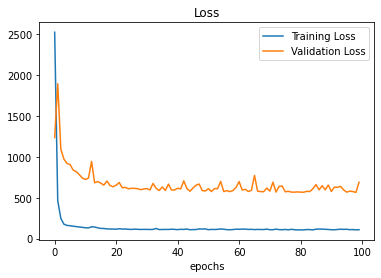

In [50]:
plot_loss_curves(history_1)

#### Try same model with dataset

In [108]:
model_1_2 = Sequential([InputLayer(input_shape = (7,)),
                        Dense(128, activation='relu'),
                        Dense(HORIZON, activation = 'linear')],
                        name = 'Model_1_2_Dense')

In [109]:
model_1_2.compile(optimizer='adam', loss = 'mae', metrics = 'mae')

In [110]:
history_1_2 = model_1_2.fit(ds_train, epochs = 100,
                            validation_data = ds_test,
                            batch_size = 128, #It doesn't work here, we had to batch our data set when we created it. Very slow model
                            callbacks = checkpoint(model_1_2.name))

Epoch 1/100
2222/2222 [==============================] - 8s 3ms/step - loss: 261.8519 - mae: 261.8519 - val_loss: 1034.4302 - val_mae: 1034.4302
INFO:tensorflow:Assets written to: time_series/Model_1_2_Dense/assets
Epoch 2/100
2222/2222 [==============================] - 8s 3ms/step - loss: 229.9582 - mae: 229.9582 - val_loss: 951.3947 - val_mae: 951.3947
INFO:tensorflow:Assets written to: time_series/Model_1_2_Dense/assets
Epoch 3/100
2222/2222 [==============================] - 8s 3ms/step - loss: 208.7112 - mae: 208.7112 - val_loss: 916.3459 - val_mae: 916.3459
INFO:tensorflow:Assets written to: time_series/Model_1_2_Dense/assets
Epoch 4/100
2222/2222 [==============================] - 8s 3ms/step - loss: 181.9294 - mae: 181.9294 - val_loss: 819.8362 - val_mae: 819.8362
INFO:tensorflow:Assets written to: time_series/Model_1_2_Dense/assets
Epoch 5/100
2222/2222 [==============================] - 8s 3ms/step - loss: 175.1448 - mae: 175.1448 - val_loss: 890.0444 - val_mae: 890.0444
Epo

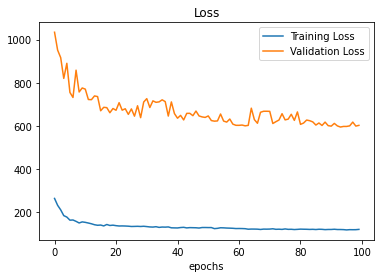

In [111]:
plot_loss_curves(history_1_2)

Why do I have this difference in results?

#### Evaluate model 1 and save results

In [73]:
model_1_load = load_model('time_series/' + model_1.name)

In [74]:
model_1_load.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 565.1944 - mae: 565.1944


[565.1943969726562, 565.1943969726562]

#### Function to load best model, make predictions and save in df_results

In [127]:
#Function to load best model, make predictions and save in df_results
def make_predictions(model, test_windows = test_windows, test_labels = test_labels, X_test = X_test):
  loaded_model  = load_model('time_series/' + model.name)
  pred = loaded_model.predict(test_windows)
  save_results(model.name, tf.squeeze(pred), tf.squeeze(test_labels))
  #Plot
  offset = 300
  plt.figure(figsize=(10, 7))
  # Account for the test_window offset and index into test_labels to ensure correct plotting
  plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
  plot_time_series(timesteps=X_test[-len(test_windows):], values=pred, start=offset, format="-", label=model.name+ " preds")
  return pred

In [93]:
pred_1 = make_predictions(model_1)

In [94]:
df_results

,model,MAE,RMSE,MAPE,MASE,last_day_pred,last_day_real
0,Base_naive,567,1071,2.52,0.99957,45604.615754,43144.471291
1,Model_1_Dense,565,1077,2.53,0.99289,45868.980469,43144.471291
2,Model_1_Dense,565,1077,2.53,0.99289,45868.980469,43144.471291
3,Model_1_Dense,565,1077,2.53,0.99289,45868.980469,43144.471291


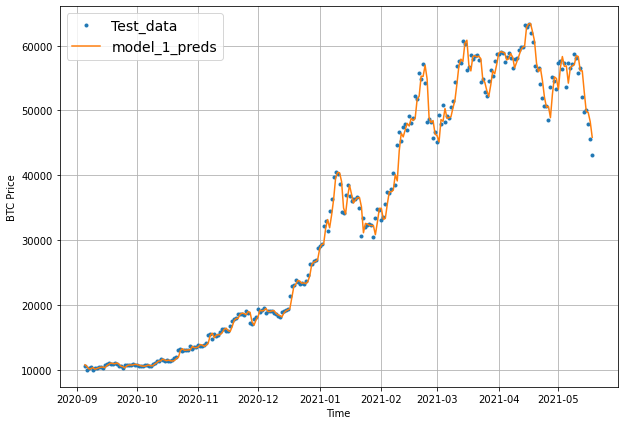

In [95]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=pred_1, start=offset, format="-", label="model_1_preds")

#### Model_1_2 evaluate

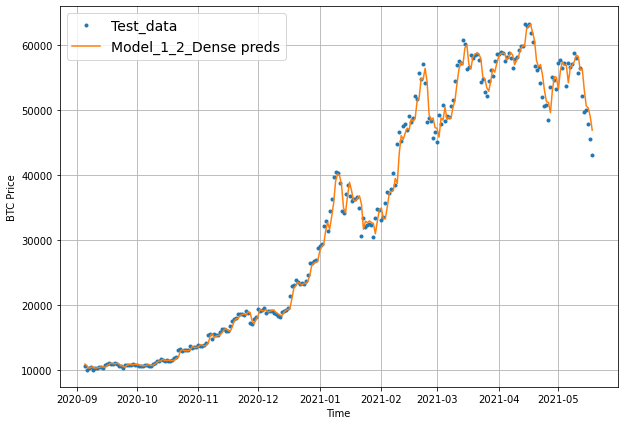

In [118]:
pred_1_2 = make_predictions(model_1_2)

In [119]:
df_results

,model,MAE,RMSE,MAPE,MASE,last_day_pred,last_day_real
0,Base_naive,567,1071,2.52,0.999570,45604.615754,43144.471291
1,Model_1_Dense,565,1077,2.53,0.992890,45868.980469,43144.471291
2,Model_1_Dense,565,1077,2.53,0.992890,45868.980469,43144.471291
3,Model_1_Dense,565,1077,2.53,0.992890,45868.980469,43144.471291
4,Model_1_2_Dense,590,1110,2.63,1.036557,46924.390625,43144.471291
5,Model_1_2_Dense,590,1110,2.63,1.036557,46924.390625,43144.471291


### 2 Model Dense Window 30 Horizon 1

In [120]:
all_windows_30, all_labels_30 = make_windows(btc_price, window_size = 30)

In [121]:
train_windows_30, test_windows_30, train_labels_30, test_labels_30 = make_train_test_splits(all_windows_30, all_labels_30, test_split=0.2)

In [122]:
model_2 = Sequential([Dense(128, activation = 'relu'),
                      Dense(HORIZON, activation = 'linear')],
                     name = 'Model_2_Dense_W30')

In [123]:
model_2.compile(optimizer = 'adam', loss = 'mae')

In [124]:
history_2 = model_2.fit(train_windows_30, train_labels_30, epochs = 100,
                        validation_data = (test_windows_30, test_labels_30),
                        batch_size = 128,
                        callbacks = checkpoint(model_2.name))

Epoch 1/100
18/18 [==============================] - 0s 10ms/step - loss: 2160.9761 - val_loss: 2645.2817
INFO:tensorflow:Assets written to: time_series/Model_2_Dense_W30/assets
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 481.3016 - val_loss: 1640.6995
INFO:tensorflow:Assets written to: time_series/Model_2_Dense_W30/assets
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 288.7314 - val_loss: 1484.6920
INFO:tensorflow:Assets written to: time_series/Model_2_Dense_W30/assets
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 252.6142 - val_loss: 1566.3446
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 218.3539 - val_loss: 1047.8671
INFO:tensorflow:Assets written to: time_series/Model_2_Dense_W30/assets
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 191.3526 - val_loss: 1088.8267
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 183.3227 - va

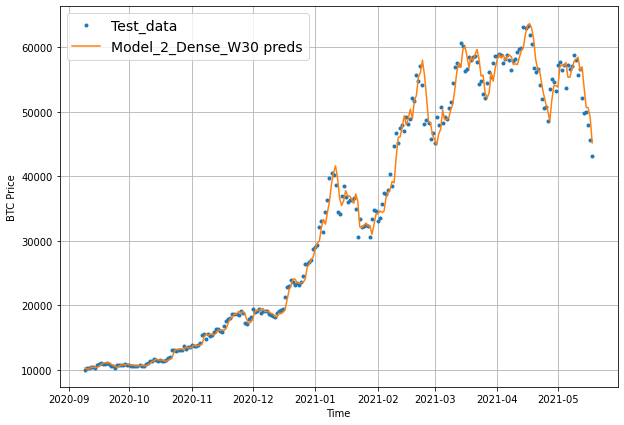

In [129]:
pred_2 = make_predictions(model_2, test_windows=test_windows_30, test_labels = test_labels_30)

In [130]:
df_results

,model,MAE,RMSE,MAPE,MASE,last_day_pred,last_day_real
0,Base_naive,567,1071,2.52,0.999570,45604.615754,43144.471291
1,Model_1_Dense,565,1077,2.53,0.992890,45868.980469,43144.471291
2,Model_1_Dense,565,1077,2.53,0.992890,45868.980469,43144.471291
3,Model_1_Dense,565,1077,2.53,0.992890,45868.980469,43144.471291
4,Model_1_2_Dense,590,1110,2.63,1.036557,46924.390625,43144.471291
5,Model_1_2_Dense,590,1110,2.63,1.036557,46924.390625,43144.471291
6,Model_2_Dense_W30,635,1186,2.89,1.111568,45195.308594,43144.471291
